# **Data analysis**

## **Training set**

In [1]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.1 MB/s eta 0:00:00


In [2]:
from Bio import SeqIO
import pandas as pd

In [65]:
neg_cols = ['ID', 'Organism_name', 'Kingdom', 'Sequence_length', 'Transmembrane']
negatives_train = pd.read_csv('training_set_neg.tsv', sep='\t', names=neg_cols)
negatives_test = pd.read_csv('test_set_neg.tsv', sep='\t', names=neg_cols)
print(negatives_train.shape)
print(negatives_test.shape)

(7147, 5)
(1787, 5)


In [66]:
pos_cols = ['ID', 'Organism_name', 'Kingdom', 'Sequence_length', 'Signal_peptide']
positives_train = pd.read_csv('training_set_pos.tsv', sep='\t', names=pos_cols)
positives_test = pd.read_csv('test_set_pos.tsv', sep='\t', names=pos_cols)
print(positives_train.shape)
print(positives_test.shape)

(874, 5)
(219, 5)


In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## **Comparison between sequence length in positive and negative entries**

In [67]:
negatives_train['Log_seq_len'] = np.log10(negatives_train['Sequence_length'])
positives_train['Log_seq_len'] = np.log10(positives_train['Sequence_length'])
positives_test['Log_seq_len'] = np.log10(positives_test['Sequence_length'])
negatives_test['Log_seq_len'] = np.log10(negatives_test['Sequence_length'])

In [68]:
negatives_train["Source"] = "negatives"
positives_train["Source"] = "positives"
training = pd.concat([negatives_train[['Log_seq_len', 'Source']], positives_train[['Log_seq_len', 'Source']]], ignore_index=True)
negatives_test["Source"] = "negatives"
positives_test["Source"] = "positives"
test = pd.concat([negatives_test[['Log_seq_len', 'Source']], positives_test[['Log_seq_len', 'Source']]], ignore_index=True)

In [69]:
print(training.head())
print(test.head())

   Log_seq_len     Source
0     2.621176  negatives
1     2.326336  negatives
2     2.805501  negatives
3     2.731589  negatives
4     2.717671  negatives
   Log_seq_len     Source
0     2.778874  negatives
1     2.260071  negatives
2     2.079181  negatives
3     2.926857  negatives
4     2.564666  negatives


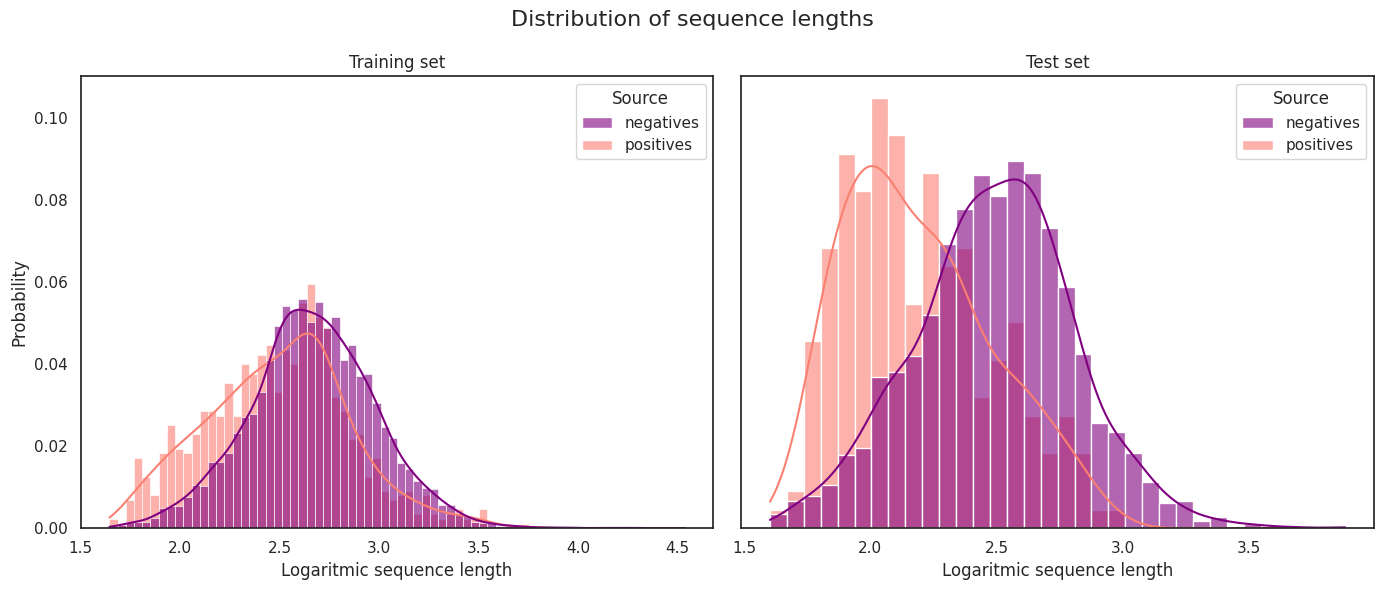

In [90]:
name = 'Sequence_length_histograms.png'
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)
sns.histplot(
    data=training,
    x='Log_seq_len',
    hue='Source',
    kde=True,
    stat='probability',
    common_norm=False,
    alpha=0.6,
    ax=axes[0]
)
axes[0].set_xlabel("Logaritmic sequence length")
axes[0].set_ylabel("Probability")
axes[0].set_title("Training set")

sns.histplot(
    data=test,
    x='Log_seq_len',
    hue='Source',
    kde=True,
    stat='probability',
    common_norm=False,
    alpha=0.6,
    ax=axes[1]
)
axes[1].set_xlabel("Logaritmic sequence length")
axes[1].set_ylabel("Probability")
axes[1].set_title("Test set")

fig.suptitle("Distribution of sequence lengths", fontsize=16)


plt.tight_layout()
plt.savefig(name, dpi=500, format='png')
plt.show()


## **Distribution of SP lengths**

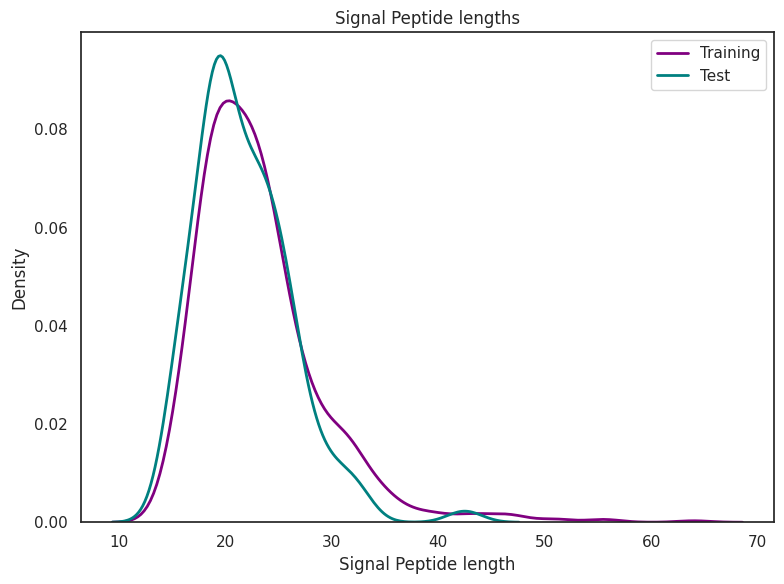

In [155]:
name_b = 'Density_SP.png'
sns.set_theme(context='notebook',
              style='white',
              palette=['orchid', 'teal'],
              font='sans-serif',
              font_scale=1,
              color_codes=True)

plt.figure(figsize=(8,6))

sns.kdeplot(
    data=positives_train,
    x='Signal_peptide',
    fill=False,
    label='Training',
    color='Purple',
    alpha=1,
    linewidth=2
)

sns.kdeplot(
    data=positives_test,
    x='Signal_peptide',
    fill=False,
    label='Test',
    color='teal',
    alpha=1,
    linewidth=2
)

plt.title("Signal Peptide lengths")
plt.xlabel("Signal Peptide length")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig(name_b, dpi=500, format='png')
plt.show()



## **Comparison of the amminoacid composition of SPs between our dataset and SwissProt data**

In [38]:
records = SeqIO.parse("cluster-results_rep_seq.fasta", "fasta")
data = {
    "id": [],
    "sequence": []
}
for record in records:
    data["id"].append(record.id)
    data["sequence"].append(str(record.seq))
pos_seqs = pd.DataFrame(data)

In [101]:
new_pos_train = pos_seqs.merge(positives_train[['ID','Signal_peptide']], how='inner', left_on='id', right_on='ID')
new_pos_train = new_pos_train.drop(columns=['ID'])
print(new_pos_train.shape)
new_pos_test = pos_seqs.merge(positives_test[['ID','Signal_peptide']], how='inner', left_on='id', right_on='ID')
new_pos_test = new_pos_test.drop(columns=['ID'])
print(new_pos_test.shape)

(874, 3)
(219, 3)


In [103]:
def cut_sp_sequence(row):
    return str(row['sequence'])[:row['Signal_peptide']]

def frequences_calculator(dataset):
  dataset['sp_sequence'] = dataset.apply(cut_sp_sequence, axis=1)
  all_seq = dataset['sp_sequence'].str.cat()
  all_seq = pd.Series(list(all_seq))
  all_seq = all_seq[all_seq != 'X']
  frequences = all_seq.value_counts(normalize=True) * 100
  return frequences

training_freq = frequences_calculator(new_pos_train)
test_freq = frequences_calculator(new_pos_test)
print(training_freq)
print(test_freq)

L    22.615225
A    13.975201
V     7.617448
S     7.553228
G     6.471373
M     6.090994
F     4.752260
P     4.520081
T     4.366942
I     4.124883
R     3.487625
C     2.860248
Q     2.158771
W     2.069851
K     2.035271
E     1.309095
H     1.121375
Y     1.032456
N     1.002816
D     0.834856
Name: proportion, dtype: float64
L    19.144475
A    15.642692
V    11.218285
S     7.443909
M     7.360034
I     6.248689
F     6.101908
T     4.864752
G     4.005033
C     3.019501
K     2.977563
P     2.285594
R     2.159782
Q     1.530719
E     1.425875
H     1.090375
N     0.985532
Y     0.964563
D     0.964563
W     0.566156
Name: proportion, dtype: float64


In [52]:
aa_freq = {
    'A': 8.25, 'Q': 3.93, 'L': 9.64, 'S': 6.65,
    'R': 5.52, 'E': 6.71, 'K': 5.79, 'T': 5.36,
    'N': 4.06, 'G': 7.07, 'M': 2.41, 'W': 1.10,
    'D': 5.46, 'H': 2.27, 'F': 3.86, 'Y': 2.92,
    'C': 1.38, 'I': 5.90, 'P': 4.74, 'V': 6.85
}
swissprot_freq = pd.Series(aa_freq)
print(swissprot_freq)


A    8.25
Q    3.93
L    9.64
S    6.65
R    5.52
E    6.71
K    5.79
T    5.36
N    4.06
G    7.07
M    2.41
W    1.10
D    5.46
H    2.27
F    3.86
Y    2.92
C    1.38
I    5.90
P    4.74
V    6.85
dtype: float64


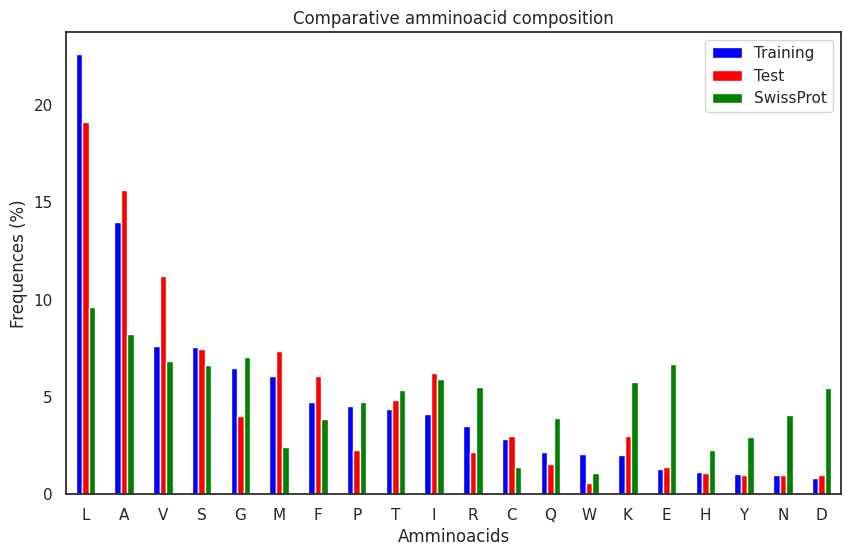

In [157]:
name_b = 'Aminoacid_composition.png'
df = pd.concat([training_freq, test_freq, swissprot_freq], axis=1)
ax = df.plot(kind="bar", figsize=(10,6), color=['blue', 'red', 'green'])
ax.legend(['Training', 'Test','SwissProt'])
ax.set_ylabel("Frequences (%)")
ax.set_xlabel("Amminoacids")
ax.set_title("Comparative amminoacid composition")
plt.xticks(rotation=0)
plt.savefig(name_b, dpi=500, format='png')
plt.show()

## **Taxonomic classification at kingdom and species level**

In [140]:
training_set = pd.concat([negatives_train[['ID','Organism_name', 'Kingdom']], positives_train[['ID','Organism_name', 'Kingdom']]], ignore_index=True)
print(training_set.shape)
test_set = pd.concat([negatives_test[['ID','Organism_name', 'Kingdom']], positives_test[['ID','Organism_name', 'Kingdom']]], ignore_index=True)
print(test_set.shape)


(8021, 3)
(2006, 3)


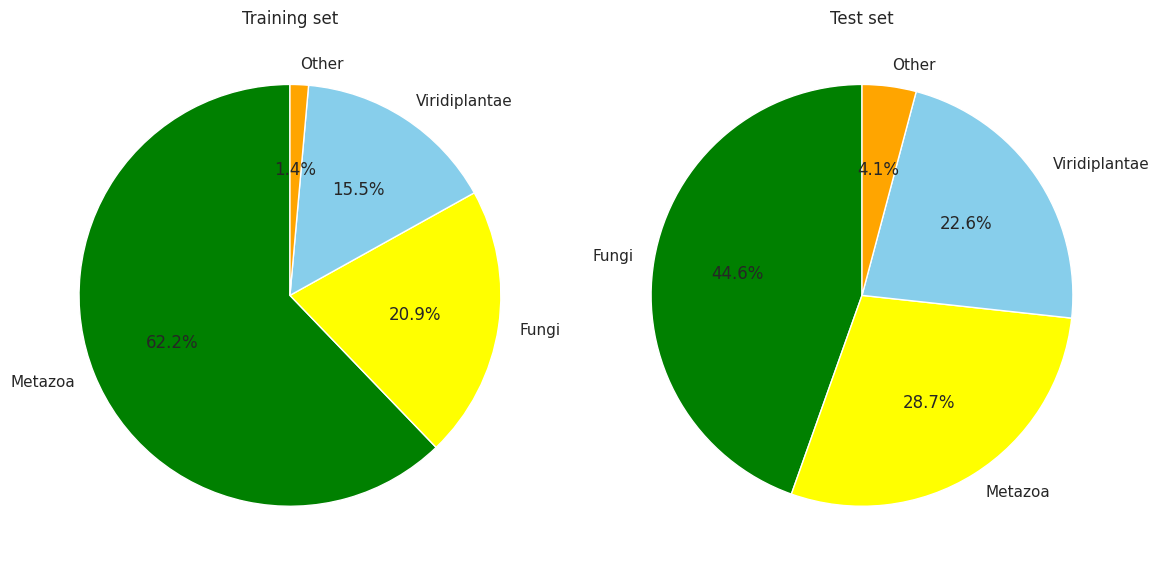

In [158]:
name_b = 'Kingdom_pie_charts.png'
kingdom_count_train = training_set['Kingdom'].value_counts()
kingdom_count_test = test_set['Kingdom'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].pie(
    kingdom_count_train,
    labels=kingdom_count_train.index,
    colors=['green', 'yellow', 'skyblue', 'orange'],
    autopct='%1.1f%%',
    startangle=90
)
axes[0].set_title("Training set")

axes[1].pie(
    kingdom_count_test,
    labels=kingdom_count_test.index,
    colors=['green', 'yellow', 'skyblue', 'orange'],
    autopct='%1.1f%%',
    startangle=90
)
axes[1].set_title("Test set")

plt.tight_layout()
plt.savefig(name_b, dpi=500, format='png')
plt.show()


In [111]:
import os

In [116]:
def cut_sp_sequence_logo(row):
  return str(row['sequence'])[(row['Signal_peptide']-13):(row['Signal_peptide']+2)]

def to_fasta(dataset, name):
    output_file = f"Logo_sequence_{name}.fasta"
    with open(output_file, "w") as logo_seq:
        for _, row in dataset.iterrows():
            logo_seq.write(f">{row['id']}\n{row['logo_sequence']}\n")
    return logo_seq

new_pos_train['logo_sequence'] = new_pos_train.apply(cut_sp_sequence_logo, axis=1)
new_pos_test['logo_sequence'] = new_pos_test.apply(cut_sp_sequence_logo, axis=1)

to_fasta(new_pos_train, 'train')
to_fasta(new_pos_test, 'test')

<_io.TextIOWrapper name='Logo_sequence_test.fasta' mode='w' encoding='utf-8'>